In [13]:
%pip install scikit-image --quiet
n = 5        
threshold = 0.001  



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


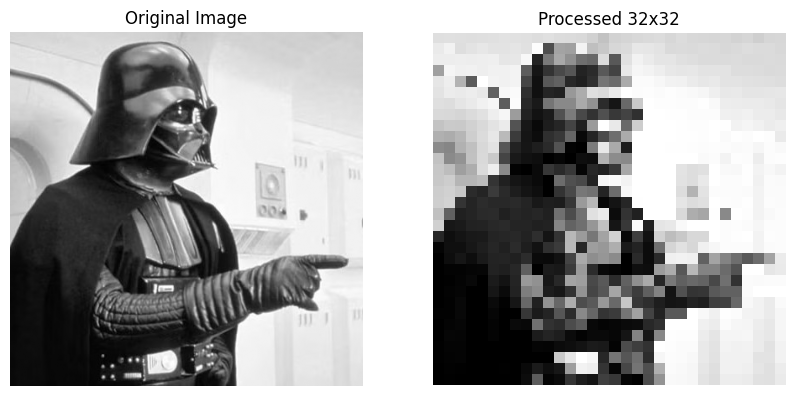

In [33]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.transform import resize

# Load a grayscale image (or convert to grayscale)
img = Image.open('/workspaces/AQA/images/Edge-Test-1.jpg').convert('L')
arr = np.array(img, dtype=float)

# First enhance edges in original resolution
arr = arr / 255.0  # Normalize to [0,1]

# Contrast stretching on original size
p2, p98 = np.percentile(arr, (2, 98))
arr = np.interp(arr, (p2, p98), (0, 1))

# Edge-preserving enhancement at original resolution
blurred = gaussian_filter(arr, sigma=1.0)
arr = arr + 0.8 * (arr - blurred)
arr = np.clip(arr, 0, 1)

# Resize with edge preservation
arr = resize(arr, (2**n, 2**n), order=3, anti_aliasing=False, mode='reflect')

# Final contrast adjustment
p5, p95 = np.percentile(arr, (5, 95))
arr = np.interp(arr, (p5, p95), (0, 1))

# Display the processed input image
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(np.array(img), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(arr, cmap='gray')
plt.title('Processed {}x{}'.format(2**n, 2**n))
plt.axis('off')
plt.show()

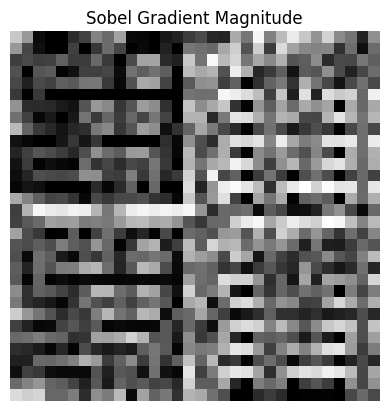

Gradient min: 8.442860417463655e-05 max: 4.175703697343002 mean: 1.616594440058571


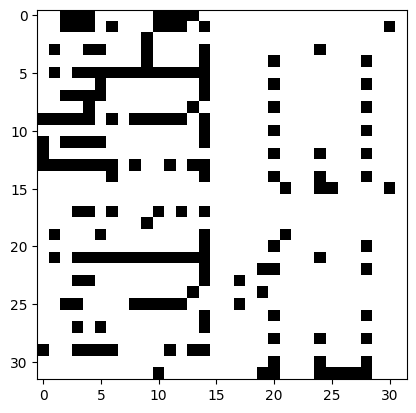

In [47]:
# Classical simulation of Sobel on the FRQI state (using statevector)
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector

# Build FRQI statevector via a circuit
pos_qubits = 2 * n
qc = QuantumCircuit(QuantumRegister(pos_qubits, 'pos'), QuantumRegister(1, 'color'))
# Initialize position in uniform superposition
qc.h(range(pos_qubits))
# Controlled rotations to encode intensities
for i in range(2**(2*n)):
    # Non-linear mapping to emphasize edges
    pixel_val = arr.flatten()[i]
    # Enhance mid-range values where edges typically occur
    theta = (np.tanh((pixel_val - 0.5) * 4) + 1) * (np.pi/4)
    angle = 2 * theta
    bits = format(i, f'0{pos_qubits}b')
    # Flip and control so that rotation applies only when position == i
    flips = []
    for j, bit in enumerate(bits):
        if bit == '0':
            qc.x(j); flips.append(j)
    qc.mcry(angle, list(range(pos_qubits)), pos_qubits)  # multi-controlled RY on color qubit
    for j in flips:
        qc.x(j)
# Simulate statevector of FRQI image
sv = Statevector.from_instruction(qc)

# Extract amplitude for each basis state where color qubit is 1
sv_data = np.array(sv.data)
amps1 = []
for i in range(2**(2*n)):
    idx = 2*i + 1  # color qubit is the least significant bit
    amps1.append(np.abs(sv_data[idx]))
amps1 = np.array(amps1) * (2**n)
img_frqi = amps1.reshape((2**n, 2**n)).astype(float)


# Classical Sobel gradients on the decoded image
from scipy import signal
Gx = np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
Gy = np.array([[1, 2,  1],[0,0, 0],[-1,-2,-1]])
img_frqi = img_frqi.astype(float)
gx = signal.convolve2d(img_frqi, Gx, mode='same', boundary='symm')
gy = signal.convolve2d(img_frqi, Gy, mode='same', boundary='symm')
gx = gx.astype(float)
gy = gy.astype(float)
g = np.hypot(gx, gy)  # gradient magnitude
plt.imshow(g, cmap='gray')
plt.title('Sobel Gradient Magnitude')
plt.axis('off')
plt.show()
print("Gradient min:", g.min(), "max:", g.max(), "mean:", g.mean())
threshold =  0.1 * g.max()  # Try 0.05, 0.2, etc.
edges_classical = (g > threshold).astype(float)
plt.imshow(edges_classical, cmap='gray')



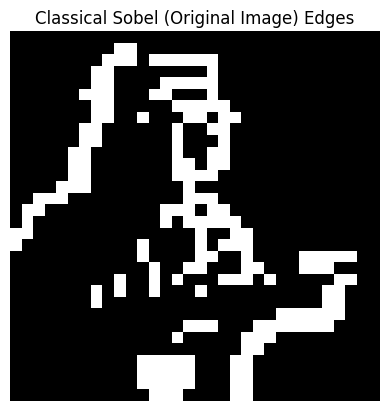

In [48]:
gx_orig = signal.convolve2d(arr, Gx, mode='same', boundary='symm')
gy_orig = signal.convolve2d(arr, Gy, mode='same', boundary='symm')
g_orig = np.hypot(gx_orig, gy_orig)
edges_orig = (g_orig > (threshold * g_orig.max())).astype(float)  # Use global threshold
plt.imshow(edges_orig, cmap='gray')
plt.title('Classical Sobel (Original Image) Edges')
plt.axis('off'); plt.show()

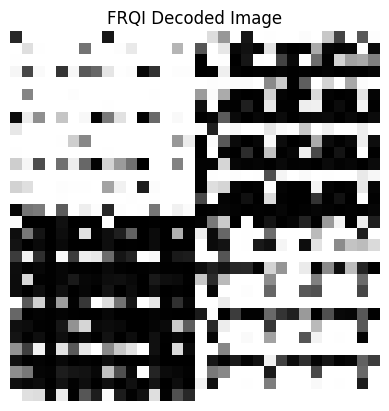

In [49]:
plt.imshow(img_frqi, cmap='gray')
plt.title('FRQI Decoded Image')
plt.axis('off')
plt.show()


=== Pre-Aer Simulation Check ===
Input image shape: (32, 32)
Input image stats: 0.0 1.0 0.5666148790779544
Circuit parameters:
- Total qubits: 11
- Angle range: 0.028 to 1.543
- Number of controlled rotations: 1024


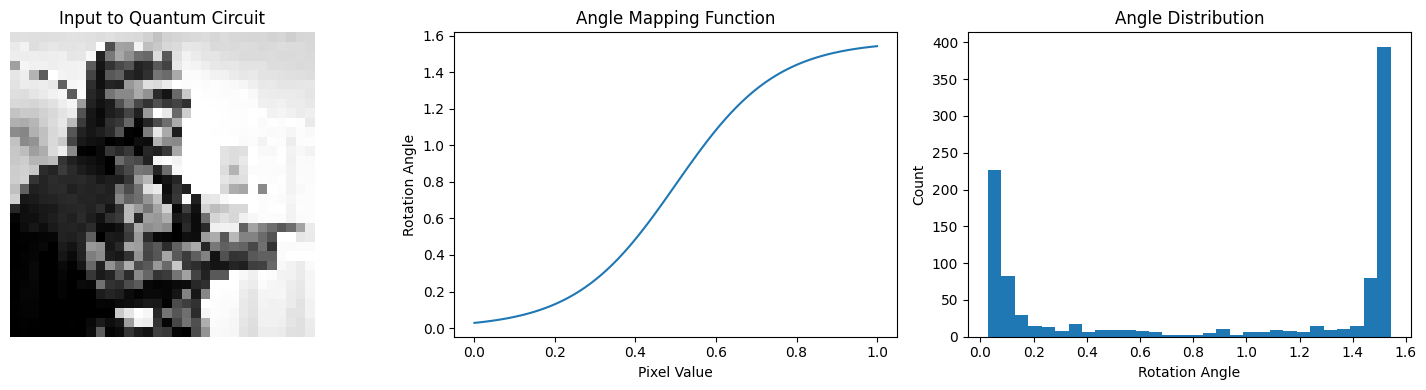

In [50]:
# Add this right before the Aer simulation cell
print("\n=== Pre-Aer Simulation Check ===")
print("Input image shape:", arr.shape)
print("Input image stats:", arr.min(), arr.max(), arr.mean())
print("Circuit parameters:")
print(f"- Total qubits: {pos_qubits + 1}")
print(f"- Angle range: {(np.tanh(-0.5 * 4) + 1) * (np.pi/4):.3f} to {(np.tanh(0.5 * 4) + 1) * (np.pi/4):.3f}")
print(f"- Number of controlled rotations: {2**(2*n)}")

# Visualize the quantum encoding parameters
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(arr.reshape((2**n, 2**n)), cmap='gray')
plt.title('Input to Quantum Circuit')
plt.axis('off')

# Plot the angle mapping function
x = np.linspace(0, 1, 100)
theta = [(np.tanh((val - 0.5) * 4) + 1) * (np.pi/4) for val in x]
plt.subplot(132)
plt.plot(x, theta)
plt.title('Angle Mapping Function')
plt.xlabel('Pixel Value')
plt.ylabel('Rotation Angle')

# Show angle distribution
angles = [(np.tanh((val - 0.5) * 4) + 1) * (np.pi/4) for val in arr.flatten()]
plt.subplot(133)
plt.hist(angles, bins=30)
plt.title('Angle Distribution')
plt.xlabel('Rotation Angle')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

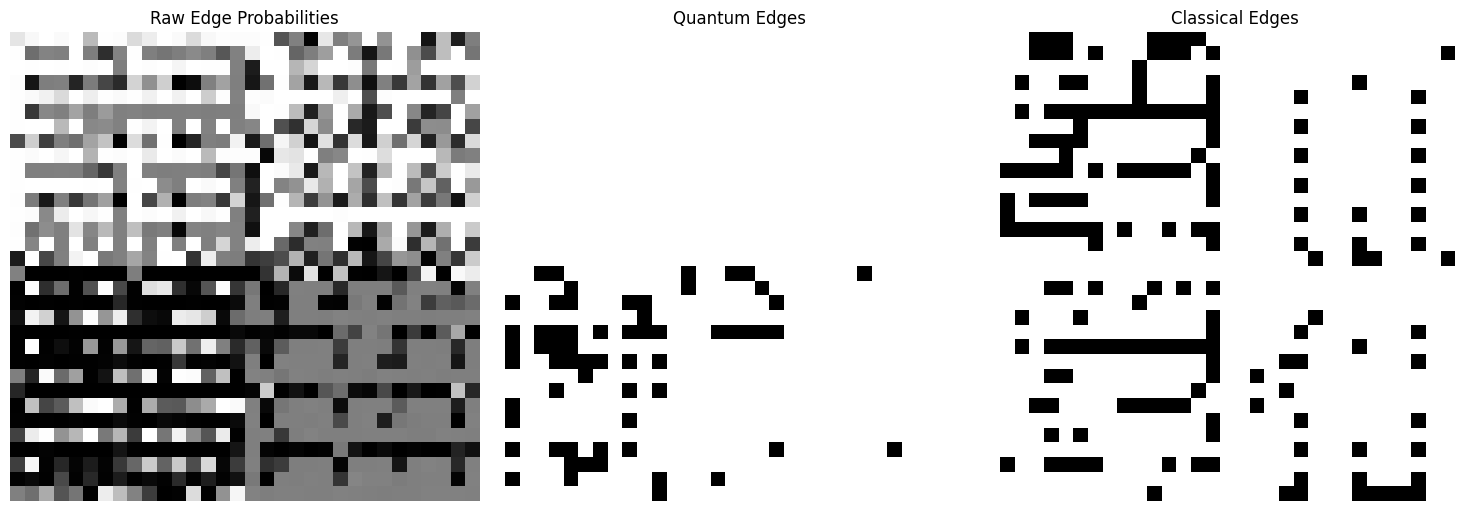

In [59]:
# Replace your Aer simulation cell with:

from qiskit_aer import Aer
from qiskit import QuantumRegister, ClassicalRegister, transpile
from scipy.ndimage import gaussian_filter, median_filter
import numpy as np

qr_pos = QuantumRegister(pos_qubits, 'pos')
qr_col = QuantumRegister(1, 'color')
cr = ClassicalRegister(pos_qubits+1, 'c')
qc2 = QuantumCircuit(qr_pos, qr_col, cr)

# Match the classical FRQI encoding exactly
qc2.h(qr_pos)
for i in range(2**(2*n)):
    pixel_val = arr.flatten()[i]
    # Use same angle mapping as classical FRQI
    theta = (np.tanh((pixel_val - 0.5) * 4) + 1) * (np.pi/4)
    angle = 2 * theta
    bits = format(i, f'0{pos_qubits}b')
    flips = []
    for j, bit in enumerate(bits):
        if bit == '0':
            qc2.x(qr_pos[j])
            flips.append(j)
    qc2.mcry(angle, list(range(pos_qubits)), pos_qubits)
    for j in flips:
        qc2.x(qr_pos[j])

qc2.barrier()
qc2.measure(qr_pos, cr[:pos_qubits])
qc2.measure(qr_col, cr[pos_qubits:])

# Increase shots for better statistics
backend = Aer.get_backend('qasm_simulator')
shots = 8388608  # 2^23 shots
qc2_t = transpile(qc2, backend, optimization_level=3)
job = backend.run(qc2_t, shots=shots)
result = job.result()
counts = result.get_counts()

# Process measurements
edge_counts = np.zeros(2**(2*n))
total_counts = np.zeros(2**(2*n))

for bitstring, cnt in counts.items():
    bitstring = bitstring.replace(' ', '')
    color_bit = bitstring[-1]  # Last bit is color qubit
    pos_bits = bitstring[:-1]  # Rest are position qubits
    idx = int(pos_bits, 2)
    if color_bit == '1':
        edge_counts[idx] += cnt
    total_counts[idx] += cnt

# Simple edge detection
edge_prob = np.where(total_counts > 0, edge_counts / total_counts, 0)
edge_prob = edge_prob.reshape((2**n, 2**n))

# Minimal post-processing
edge_prob_smooth = gaussian_filter(edge_prob, sigma=0.5)
threshold = 0.1 * edge_prob_smooth.max()  # Match classical threshold
edges_qsim = (edge_prob_smooth > threshold).astype(float)

# Visualization
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(edge_prob, cmap='gray')
plt.title('Raw Edge Probabilities')
plt.axis('off')

plt.subplot(132)
plt.imshow(edges_qsim, cmap='gray')
plt.title('Quantum Edges')
plt.axis('off')

plt.subplot(133)
plt.imshow(edges_classical, cmap='gray')
plt.title('Classical Edges')
plt.axis('off')

plt.tight_layout()
plt.show()

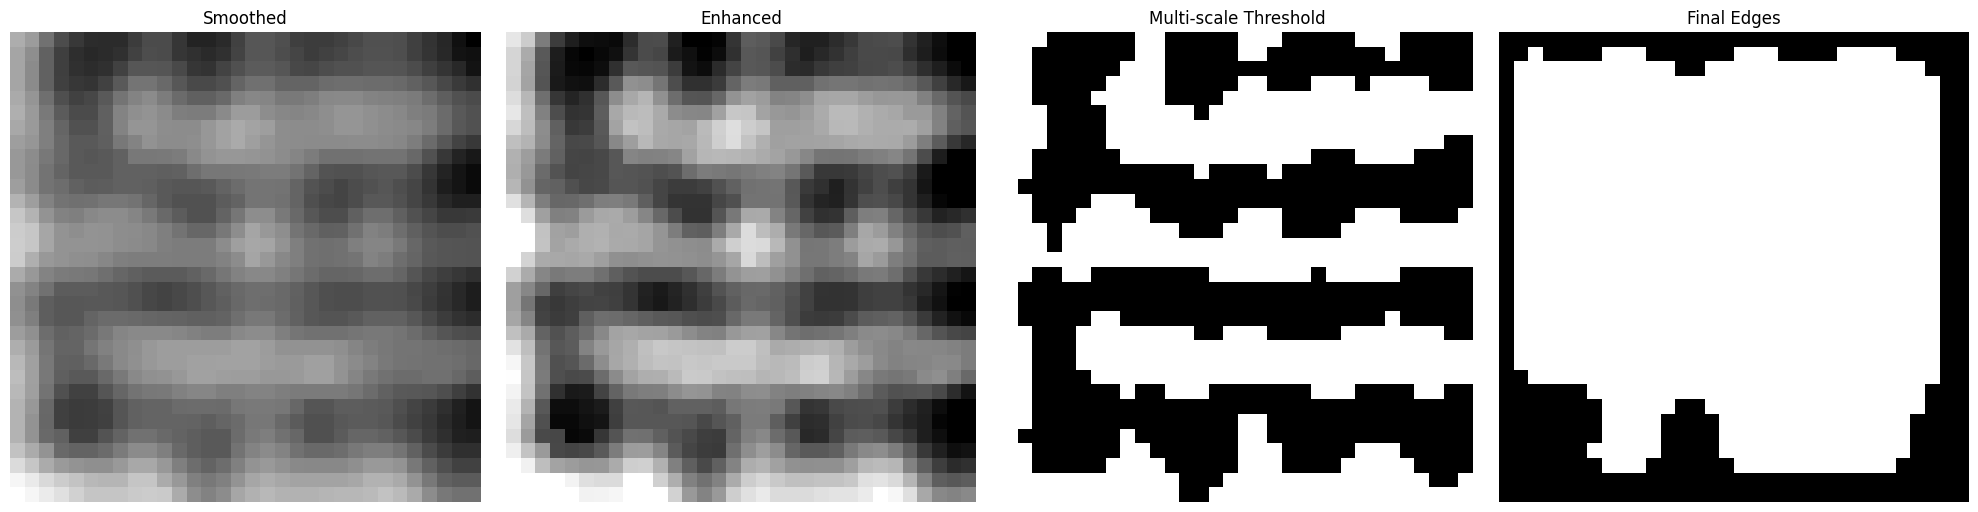

In [57]:
from scipy.ndimage import gaussian_filter, binary_dilation, binary_closing, median_filter
from skimage.filters import threshold_local

# 1. Enhanced smoothing with edge preservation
edge_prob_smooth = gaussian_filter(edge_prob.reshape((2**n, 2**n)), sigma=1.5)
edge_prob_smooth = median_filter(edge_prob_smooth, size=3)

# 2. Stronger contrast enhancement
p2, p98 = np.percentile(edge_prob_smooth, (0.5, 99.5))  # Even more aggressive stretch
edge_prob_stretched = np.interp(edge_prob_smooth, (p2, p98), (0, 1))

# 3. Edge enhancement
blurred = gaussian_filter(edge_prob_stretched, sigma=2.0)
edge_prob_enhanced = edge_prob_stretched + 0.8 * (edge_prob_stretched - blurred)
edge_prob_enhanced = np.clip(edge_prob_enhanced, 0, 1)

# 4. Multi-scale adaptive thresholding
window_sizes = [7, 11, 15]
edges_multi = np.zeros_like(edge_prob_enhanced)
for window in window_sizes:
    local_thresh = threshold_local(edge_prob_enhanced, window, offset=0)
    edges_multi += (edge_prob_enhanced > local_thresh).astype(float)
edges_qsim = (edges_multi >= 2).astype(float)  # Keep edges detected at multiple scales

# 5. Advanced morphological cleanup
structure1 = np.ones((3,3))
structure2 = np.ones((2,2))
edges_clean = binary_closing(edges_qsim, structure=structure1, iterations=2)
edges_clean = binary_dilation(edges_clean, structure=structure2)
edges_clean = median_filter(edges_clean, size=3)

# Visualization with all steps
plt.figure(figsize=(20, 5))
plt.subplot(141)
plt.imshow(edge_prob_smooth, cmap='gray')
plt.title('Smoothed')
plt.axis('off')

plt.subplot(142)
plt.imshow(edge_prob_enhanced, cmap='gray')
plt.title('Enhanced')
plt.axis('off')

plt.subplot(143)
plt.imshow(edges_qsim, cmap='gray')
plt.title('Multi-scale Threshold')
plt.axis('off')

plt.subplot(144)
plt.imshow(edges_clean, cmap='gray')
plt.title('Final Edges')
plt.axis('off')

plt.tight_layout()
plt.show()

In [58]:
print("Quantum edge_prob min:", edge_prob.min(), "max:", edge_prob.max(), "mean:", edge_prob.mean())

Quantum edge_prob min: 0.009567338658128465 max: 0.8472194723267092 mean: 0.4523415965964006
